# Bidirectional Encoder Representations from Transformers (BERT)

While BERT shares some architectural similarities with autoregressive models like GPT, its primary objective is text understanding rather than generation. This focus makes BERT particularly effective for tasks such as sentiment analysis — evaluating the positivity of a product review — or determining whether an answer to a question is correct.

In transformer architectures, the encoder transforms the input sequence into a dense, abstract representation that captures its semantic content. In generation models, a projection head then converts this representation back into text. In contrast, an encoder-only model like BERT is designed to produce a rich and meaningful representation of the input, which can then be used directly for various downstream tasks without requiring text generation.

https://arxiv.org/abs/1810.04805

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# defining the device the data ends up living
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Defining the Model

A BERT-style model, as a variant of the Transformer architecture, represents each token as a high-dimensional vector. These vectors encode semantic and syntactic information, enabling the model to reason about words and capture a rich understanding of the input text. Therefore, it is essential to convert raw tokens (integers) into these dense vector representations through a learned embedding process.

# Embedding

The embedding module is responsible for converting tokens into vector representations while incorporating positional information. This is achieved through learned lookup tables for three types of embeddings:

- **Token embeddings:** Each token in the vocabulary is mapped to a unique vector representation.
- **Positional embeddings:** Each position in the input sequence is assigned a distinct vector, enabling the model to capture word order.
- **Segment embeddings:** Distinct vectors are assigned to differentiate between segments in tasks involving multiple sentences.

Initially, these embeddings are randomly initialized, meaning they do not carry meaningful information. However, since they are learnable parameters, the model gradually refines them through training, optimizing representations for both token identities and positional encoding.

In [4]:
class Embedding(nn.Module):
    """
    This is the first component of the model which converts tokens into vectors. These vectors
    are learned throughout the training process, where there's esssentially a lookup table for
    each word.
    """

    def __init__(self, d_model, vocab_size, input_length, n_segments, dropout=0.1) -> None:
        super(Embedding, self).__init__()
        # token embedding
        self.tok_embed= nn.Embedding(vocab_size, d_model)
        # position embedding
        self.pos_embed= nn.Embedding(input_length, d_model)
        # segment (token type) embedding
        self.seg_embed= nn.Embedding(n_segments, d_model)

        # apply layer normalization and dropout
        self.norm= nn.LayerNorm(d_model)
        self.dropout= nn.Dropout(p=dropout)


    def forward(self, x, seg_location):
        batch_size, seq_len= x.shape
        pos= torch.arange(0, seq_len, dtype=torch.long, device=x.device)  # [seq_len, ]
        pos= pos.unsqueeze(0).expand(batch_size, seq_len)  # [batch_size, seq_len]
        # get embeddings
        tok_emb= self.tok_embed(x)  # [batch_size, seq_len, d_model]
        pos_emb= self.pos_embed(pos)
        seg_emb= self.seg_embed(seg_location.long())
        # combine embeddings
        embedding= tok_emb + pos_emb + seg_emb

        return self.dropout(self.norm(embedding))


# Multi-Headed Self-Attention

BERT follows a transformer-based architecture, where Multi-Head Self-Attention (MHSA) is a fundamental component.

In our implementation, a batch of input sequences is first projected into Query, Key, and Value representations. These representations are then split into multiple attention heads, introducing an additional dimension for parallelization. Since PyTorch inherently parallelizes computations along the batch dimension (0th axis), we leverage this behavior by merging the batch and head dimensions, enabling efficient parallel computation across both.

Key hyperparameters in our implementation include:

- **n_heads** specifies the number of attention heads in each MHSA block.
- **query_key_dim** specifies the dimensionality of the Query and Key vectors.
- **value_dim** specifies the dimensionality of the Value vectors.

These hyperparameters influence the model's ability to capture diverse feature interactions while maintaining computational efficiency.

In [5]:
class MultiHeadSelfAttention(nn.Module):
    """
    MHSA has four sets of parameters -- all dense linear modules. Three of them turn the model's
    input tensors into inputs for MHSA, and the other turns the output of MHSA back into the
    shape needed for modeling (d_model).
    """

    def __init__(self, d_model, query_key_dim, value_dim, n_heads, dropout=0.1) -> None:
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.query_key_dim= query_key_dim
        self.value_dim= value_dim
        self.n_heads= n_heads
        # defining the linear layers that construct the Query, Key, and Value
        self.W_Q= nn.Linear(d_model, n_heads * query_key_dim)
        self.W_K= nn.Linear(d_model, n_heads * query_key_dim)
        self.W_V= nn.Linear(d_model, n_heads * value_dim)
        # dropout module for regularization
        self.dropout= nn.Dropout(p=dropout)
        # projects final output of MHSA back into model dimension
        self.o_proj= nn.Linear(n_heads * value_dim, d_model)


    def forward(self, x):
        batch_size, seq_len, _= x.size()
        # passing x (embedding) through dense networks
        q= self.W_Q(x) # [batch_size, seq_len, (n_heads * query_key_dim)]
        k= self.W_K(x) # [batch_size, seq_len, (n_heads * query_key_dim)]
        v= self.W_V(x) # [batch_size, seq_len, (n_heads * value_dim)]

        # dividing out heads -- [batch_size, seq_len, n_heads, qk/v_dim]
        q= q.view(batch_size, -1, self.n_heads, self.query_key_dim).transpose(1, 2)
        k= k.view(batch_size, -1, self.n_heads, self.query_key_dim).transpose(1, 2)
        v= v.view(batch_size, -1, self.n_heads, self.value_dim).transpose(1, 2)
        # and then moving the head dimension next to the batch dimension
        # [batch_size, n_heads, seq_len, qk/v_dim]

        # passing batches/heads through the 'scaled dot product'
        attn= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # normalize Attention scores
        attn= F.softmax(attn, dim=-1)
        attn= self.dropout(attn)
        # compute Attention output
        context= attn @ v  # [batch, head, seq_len, head_dim]

        # permuting back between head and seq_len dimensions
        context= context.transpose(1, 2)  # [batch_size, seq_len, n_heads, value_dim]
        # combining the last dim to effectively concatenate the result of the heads
        # [batch_size, seq_len, (n_heads * value_dim)]
        context= context.contiguous().view(batch_size, seq_len, -1)

        # projecting result of head back into model dimension
        return self.o_proj(context)


# Pointwise Feed-Forward Network

This module corresponds to the Feed-Forward Network (FFN) in BERT, which is applied independently to each word vector. The FFN consists of a multi-layer perceptron (MLP) that first expands the dimensionality of the input representation, allowing the model to capture a broader range of features. This expanded representation undergoes nonlinear transformations, enabling the network to model complex dependencies and interactions. Finally, the output is projected back to the original embedding dimension, ensuring compatibility with the residual connection while preserving the enriched feature representations.

In [6]:
class PointwiseFeedForwardNet(nn.Module):
    """
    In this implementation we are expanding the input tensors to four times their size (default
    is d_ff= 4 * d_model), applying a non-linear activation function, then compressing that data
    back into the original model dimension length (d_model).
    """

    def __init__(self, d_model, d_ff, dropout=0.1) -> None:
        super(PointwiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.gelu= nn.GELU()
        self.dropout= nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(d_ff, d_model)


    def forward(self, x):
        x= self.fc1(x)  # [batch_size, seq_len, d_model] -> [batch_size, seq_len, d_ff]
        x= self.gelu(x)
        x= self.dropout(x)
        x= self.fc2(x)  # [batch_size, seq_len, d_ff] -> [batch_size, seq_len, d_model]

        return x


In [ ]:
# example usage
d_model= 256
d_ff= 4 * d_model

sample= PointwiseFeedForwardNet(d_model=d_model, d_ff=d_ff).to(device)
sample_embeddings= torch.tensor([[[1.1] * d_model] * 64] * 128).to(device)
sample(sample_embeddings).shape

torch.Size([128, 64, 256])

# The Transformer Encoder Block

With the Multi-Head Self-Attention (MHSA) and Feed-Forward Network (FFN) components defined, we can now construct a single encoder block. The encoder block follows these steps:

- The input is processed by the MHSA module.
- A residual connection is applied by adding the original input to the MHSA output, followed by layer normalization.
- The result is passed through the FFN.
- Another residual connection is applied by adding the FFN output to the previous result, followed by a second layer normalization.

These residual connections facilitate gradient flow during training, mitigating the vanishing gradient problem and allowing the model to integrate both low-level and high-level representations effectively.

**NOTE:** Very few details about the Transformer architecture have changed in the last five years, but there is something slightly departs from the original paper. You see that Add and Norm is applied **after** (Post-LN) the transformation (Multi-Headed Self-Attention). But now it is more common to apply LayerNorm **before** (Pre-LN) the transformation, so there is a reshuffling of the Layer Norm. This is called **pre-norm formulation** and that is the one we are going to implement as well.

In [7]:
class EncoderBlock(nn.Module):
    """
    The Encoder block connects Self-Attention and FeedForward Network through LayerNorms and
    residual connections.
    Pre-normalization: LayerNorms are before the application of Attention and FeedForward
    in order to keep a clean residual stream all the way down to the input tokens.
    """

    def __init__(self, d_model, d_ff, query_key_dim, value_dim, n_heads, dropout=0.1) -> None:
        super(EncoderBlock, self).__init__()

        self.norm1= nn.LayerNorm(d_model)
        self.mhsa= MultiHeadSelfAttention(d_model, query_key_dim, value_dim, n_heads, dropout)
        self.dropout1= nn.Dropout(p=dropout)

        self.norm2= nn.LayerNorm(d_model)
        self.pffn= PointwiseFeedForwardNet(d_model, d_ff, dropout)
        self.dropout2= nn.Dropout(p=dropout)


    def forward(self, x):
        # apply residual connection to Attention
        x_norm= self.norm1(x)
        x= x + self.dropout1(self.mhsa(x_norm))
        # apply residual connection to FFN
        x_norm= self.norm2(x)
        x= x + self.dropout2(self.pffn(x_norm))

        return x


In [ ]:
# example usage
sample= EncoderBlock(d_model, d_ff, query_key_dim=64, value_dim=64, n_heads=4).to(device)
sample_embeddings= torch.tensor([[[1.1] * d_model] * 64] * 128).to(device)
sample(sample_embeddings).shape

torch.Size([128, 64, 256])

# The Encoder Module

The encoder is composed of a stack of identical EncoderBlocks (or layers).

In [8]:
class TransformerEncoder(nn.Module):
    """
    The Transformer Encoder is essentially a stack of N Encoder Blocks.
    """

    def __init__(self, n_layers=12, d_model=768, d_ff=3072, n_heads=12, query_key_dim=64,
                 value_dim=64, dropout=0.1) -> None:
        super(TransformerEncoder, self).__init__()

        self.transformer= nn.ModuleList([
            EncoderBlock(d_model, d_ff, query_key_dim, value_dim, n_heads, dropout)
            for _ in range(n_layers)
        ])
        # final LayerNorm after the transformer
        self.ln_final= nn.LayerNorm(d_model, eps=1e-12)


    def forward(self, x):
        for block in self.transformer:
            x= block(x)

        return self.ln_final(x)


# Output Heads

The encoder output of the final encoder block will feed into output heads:

- A dense network for MLM (masked language mode) task, projecting word vectors into probabilities.
- A dense network for NSP (Next Sentence Prediction) task, classifying if sequences are a positive pair.

In [9]:
class ProjectionHead(nn.Module):
    """
    The MLP projection head for MLM task.
    Standard BERT has dropout before the final projection.
    """

    def __init__(self, d_model, vocab_size, bias=False, dropout=0.1) -> None:
        super(ProjectionHead, self).__init__()
        self.p_head= nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(d_model, vocab_size, bias=bias),
        )


    def forward(self, x):

        return self.p_head(x)


In [10]:
class ClassifierHead(nn.Module):
    """
    The MLP classification head for NSP task.
    Standard BERT applies a non-linearity before classification.
    """

    def __init__(self, d_model, num_classes, bias=True, dropout=0.1, fine_tune=False) -> None:
        super(ClassifierHead, self).__init__()
        if fine_tune:
            self.c_head= nn.Linear(d_model, num_classes, bias=bias)
        else:
            self.c_head= nn.Sequential(
                nn.Linear(d_model, d_model, bias=bias),
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(d_model, num_classes, bias=bias),
            )


    def forward(self, x):

        return self.c_head(x)


# Building BERT

BERT follows a straightforward structure when we understand the key components we have already created:

- **Embedding Module:** Converts token IDs into dense vector representations, incorporating token, positional, and segment embeddings.
- **Stacked Transformer Encoder Blocks:** Sequentially process the input, leveraging Multi-Head Self-Attention (MHSA) and Feed-Forward Networks (FFN) to refine contextual representations.
- **Projection Head:** Maps the output representations to token prediction probabilities for masked language modeling.
- **Classifier:** Uses the representation of the special [CLS] token to predict whether the input sequences form a coherent pair.

In summary, a complete BERT model consists of multiple stacked Transformer encoder blocks, enabling it to capture complex contextual relationships across input sequences.

In [11]:
class BERT(nn.Module):
    """
    BERT consists of the following:
    - An embedding module
    - A list of transformer encoder blocks
    - A dense network for projecting word vectors into probabilities (MLM)
    - A dense network for classifying if sequences are a positive pair (NSP)
    """

    def __init__(self, vocab_size, input_length, n_segments, n_layers=12, d_model=768, d_ff=3072,
                 n_heads=12, query_key_dim=64, value_dim=64, dropout=0.1, fine_tune=False) -> None:
        super(BERT, self).__init__()
        self.input_length= input_length

        # for converting tokens into vector embeddings
        self.embedding= Embedding(d_model, vocab_size, input_length, n_segments, dropout)
        # transformer encoder blocks stacked on top of each other
        self.encoder_blocks= TransformerEncoder(
            n_layers, d_model, d_ff, n_heads, query_key_dim, value_dim, dropout
        )
        # for projecting a word vector (or tensor of them) into token predictions
        self.proj_head= ProjectionHead(d_model, vocab_size, bias=False, dropout=dropout)
        # for converting the first output token into a binary classification
        self.classifier= ClassifierHead(d_model, 1, bias=True, dropout=dropout, fine_tune=fine_tune)

        # initialize Linear modules with Glorot / fan_avg
        # let LayerNorm and Embedding modules use default initializations
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):  # 0.02 is close of that used in xavier init
                nn.init.normal_(m.weight, mean=0.0, std=0.02)


    def forward(self, x, seg_location, masked_token_locations=None):
        # x is our token indices of shape [batch_size x seq_len]
        batch_size, seq_len= x.size()
        assert seq_len <= self.input_length, \
            f"Cannot forward sequence of length {seq_len}, block size is only {self.input_length}"

        embeddings= self.embedding(x, seg_location)
        x= embeddings  # x of shape [batch x seq_len x model_dim]

        x= self.encoder_blocks(x)

        # for every example in the batch, this takes the first vector and passes it to the
        # classifier linear network for prediction
        clsf_logits= self.classifier(x[:, 0, :])

        token_logits= None
        if masked_token_locations is not None:
            # passing masked tokens through the projection head
            masked_token_embeddings= embeddings[masked_token_locations.bool()]
            token_logits= self.proj_head(masked_token_embeddings)

        return clsf_logits, token_logits


The classifier is implemented as a linear module with a single output unit, as it performs a binary classification task. Predictions greater than 0.5 are interpreted as *true*, while values below 0.5 are considered *false*.

The projection head operates similarly but focuses on masked tokens. Instead of making a binary decision, it predicts the most likely token for each masked position. Consequently, its output dimension matches **vocab_size** (from a tokenizer vocabulary), allowing the model to select the correct token from the entire vocabulary.

In [12]:
# --- BERT LARGE hyperparameters config ---
vocab_size= 30522
input_length= 512
n_segments= 2
N= 24
d_model= 1024
d_ff= 4 * d_model
h= 16
dk= 64
dv= 64
dropout= 0.1

model= BERT(vocab_size, input_length, n_segments, N, d_model, d_ff, h, dk, dv, dropout).to(device)

count_parameters(model)
model

Number of parameters: 366399489


BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(30522, 1024)
    (pos_embed): Embedding(512, 1024)
    (seg_embed): Embedding(2, 1024)
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): TransformerEncoder(
    (transformer): ModuleList(
      (0-23): 24 x EncoderBlock(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mhsa): MultiHeadSelfAttention(
          (W_Q): Linear(in_features=1024, out_features=1024, bias=True)
          (W_K): Linear(in_features=1024, out_features=1024, bias=True)
          (W_V): Linear(in_features=1024, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (pffn): PointwiseFeedForwardNet(
       

# Training the BERT model from scratch

In [ ]:
!pip install nltk
!pip install datasets

import random
import nltk
import itertools
from datasets import load_dataset
from multiprocessing import Pool, cpu_count
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# a sentence tokenizer we will be using to extract sentences from articles
nltk.download('punkt_tab')

# the dataset is big, to make things easier we are going to be streaming a subset
dataset= load_dataset('wikipedia', '20220301.en', trust_remote_code= True, streaming=True)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

In [ ]:
# breaking wikipedia articles into sentences and paragraphs
num_articles= 10000

# geting n articles
dataset_iter= iter(dataset['train'])
articles= list(itertools.islice(dataset_iter, num_articles))

# getting paragraphs
paragraphs= []
for article in articles:
    paragraphs.extend(article['text'].splitlines())

# filtering paragraphs so they are hopefully actually paragraphs
paragraphs= [p for p in paragraphs if len(p) > 50]

# dividing paragraphs into sentences
divided_paragraphs= [nltk.sent_tokenize(p) for p in paragraphs]

# only using paragraphs with 3 or more sentences
divided_paragraphs= [pls for pls in divided_paragraphs if len(pls) >= 3]


In [ ]:
# using the paragraph data to construct paris of following sentences and pairs
# of random sentences
positive_pairs= []
negative_pairs= []
num_paragraphs= len(divided_paragraphs)

for i, paragraph in enumerate(divided_paragraphs):
    for j in range(len(paragraph) - 1):
        positive_pairs.append((paragraph[j], paragraph[j+1]))
        rand_par= i

        # avoiding to take a sentence from the same paragraph
        while rand_par == i or len(divided_paragraphs[rand_par]) < 1:
            rand_par= random.randint(0, num_paragraphs-1)

        rand_sent= random.randint(0, len(divided_paragraphs[rand_par])-1)
        negative_pairs.append((paragraph[j], divided_paragraphs[rand_par][rand_sent]))


# Tokenization

In order to feed data into our model we need to somehow turn our sentences into vectors. We can use that to break up text into individual tokens.

In [ ]:
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast

tokenizer= BertTokenizerFast.from_pretrained('google-bert/bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# playing arround with tokenizer
sentence= "Here's a weird word: Withoutadoubticus."
print(f'Original sentence: "{sentence}"')

demo_tokens= tokenizer([sentence])
print(f"Token IDs: {demo_tokens['input_ids']}")

tokens= tokenizer.convert_ids_to_tokens(demo_tokens['input_ids'][0])
print(f'Token values: {tokens}')

Original sentence: "Here's a weird word: Withoutadoubticus."
Token IDs: [[101, 2182, 1005, 1055, 1037, 6881, 2773, 1024, 2302, 9365, 12083, 29587, 1012, 102]]
Token values: ['[CLS]', 'here', "'", 's', 'a', 'weird', 'word', ':', 'without', '##ado', '##ub', '##ticus', '.', '[SEP]']


The tokenizer broke our sentence up into individual components which may have included dividing individual words into more than one component. This is called sub-word tokenization, meaning the tokenizer has both words and word components in its vocabulary. This is important because it allows the tokenizer to express complicated words as a series of tokens.

In [ ]:
# special tokens
tokenizer

BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

# Defining Training Batches

Each batch will contain 128 individual sentence pair examples, 64 of which are positive pairs and 64 of which are negative pairs. To keep our model fairly small, to speed up training, we'll make the context window for our model equal to 64 tokens. So, at the end of this process, we'll get a tensor which is [number_of_batches x 64(batch_size) x 64(sequence_length)]

In [ ]:
# number of examples in the batch -- should be divisible by 2
batch_size= 128
# sequence length of model
max_input_length= 64

# defining parallelizable function for processing batches
def process_batch(batch_index):
    """
    Processes a batch of sentence pairs (both positive and negative examples),
    tokenizes them, applies truncation and padding, and returns tensors
    for training a BERT-based model.
    """
    # establishing bounds of the batch
    start_index= batch_index * batch_size
    end_index= min(start_index + batch_size, len(positive_pairs), len(negative_pairs))

    # Ensure we don't return an incomplete batch
    actual_batch_size= end_index - start_index
    if actual_batch_size < batch_size // 2:
        return None, None, None

    # getting the sentence pairs of the batch, and if they are pos or neg
    sentence_pairs= (
        positive_pairs[start_index:start_index + batch_size // 2] +
        negative_pairs[start_index:start_index + batch_size // 2]
    )
    is_positives= [1] * (batch_size // 2) + [0] * (batch_size // 2)

    # defining outputs
    # at the end of the day we need to know three things:
    # - the tokens for the sequences in a batch
    # - which sentence the tokens belong to, for positional encoding
    # - if the examples in the batch are positive or negative
    # these keep track of the first two
    batch_sentence_location_tokens= []
    batch_sequence_tokens= []

    # tokenizing pairs
    for sentence_pair in sentence_pairs:
        sentence1= sentence_pair[0]
        sentence2= sentence_pair[1]

        # tokenizing both sentences
        tokens= tokenizer([sentence1, sentence2], truncation=True, padding=False,
                          max_length=max_input_length)
        sentence1_tokens= tokens['input_ids'][0]
        sentence2_tokens= tokens['input_ids'][1]

        # trimming down tokens
        if len(sentence1_tokens) + len(sentence2_tokens) > max_input_length:
            max_half= max_input_length // 2  # leaving space for [CLS] and [SEP]
            """
            If the sentences are too long, preserves the end of the first sentence and the
            beginning of the second sentence. This should still allow long inputs to be
            reasonably interpretable by the model.
            """
            sentence1_tokens= [101] + sentence1_tokens[-(max_half -1):]
            sentence2_tokens= sentence2_tokens[:(max_half -1)] + [102]

        # creating sentence tokens - a vector which has zeros in the length of the first sentence,
        # and ones for the length of the second sentence. We'll use this vector to help us with
        # positional encoding when we go to build the model.
        sentence_tokens= [0] * len(sentence1_tokens) + [1] * len(sentence2_tokens)

        # combining and padding
        pad_num= max_input_length - (len(sentence1_tokens) + len(sentence2_tokens))
        sequence_tokens= sentence1_tokens + sentence2_tokens + [0] * pad_num
        sentence_location_tokens= sentence_tokens + [1] * pad_num
        """
        We combine our sentence tokens together, and if the combined length is less than the model
        length we add a bunch of pad tokens. If we do add pad tokens, we say the pad tokens belong
        to the second sentence for convenience sake.
        """
        # adding to batch
        batch_sequence_tokens.append(sequence_tokens)
        batch_sentence_location_tokens.append(sentence_location_tokens)

    return (
        torch.tensor(batch_sentence_location_tokens, dtype=torch.long),
        torch.tensor(batch_sequence_tokens, dtype=torch.long),
        torch.tensor(is_positives, dtype=torch.long)
    )


In [ ]:
# determine the number of batches
num_batches= len(positive_pairs) // batch_size

# use a pool of workers equal to the number of CPU cores
with Pool(processes=cpu_count()) as pool:
    results= list(tqdm(pool.imap(process_batch, range(num_batches)), total=num_batches))

# filter out None results from the process_batch function
results= [result for result in results if result[0] is not None]

# unpack results into batches
sentence_location_batches, sequence_tokens_batches, is_positives_batches= zip(*results)

# stack tensors into final batches and move to device
sentence_location_batches= torch.stack(sentence_location_batches).to(device)
sequence_tokens_batches= torch.stack(sequence_tokens_batches).to(device)
is_positives_batches= torch.stack(is_positives_batches).to(device)

100%|██████████| 7311/7311 [04:01<00:00, 30.28it/s]


In [ ]:
sentence_location_batches.shape

torch.Size([7311, 128, 64])

# Creating a Masking Function

As we build our masking function we don't want to inadvertently mask out special tokens like [CLS], [SEP], and [PAD]. We only want to mask out tokens which correspond to the sentences themselves.

After we train our model, the [MASK] token will never be seen when the model is actually being used and making inferences. If we only train our model on the [MASK] token, it might learn to disregard other words that might be important in understanding the sequence generally. So, when we decide a random token should be masked we usually replace it with the [MASK] token, but we also sometimes preserve the original token value, and sometimes replace the masked token with a
completely random token.

In the original BERT paper they decided to mask 15% of words within the input. Of that 15%, 80% are replaced with [MASK], while 10% are replaced with a random word and 10% are not replaced at all.

In [ ]:
# listing out vocab for random token masking
vocab= tokenizer.get_vocab()
valid_token_ids= torch.tensor(list(vocab.values()), device=device)

def mask_batch(batch_tokens, clone=True):
    if clone:
        batch_tokens= torch.clone(batch_tokens)

    # define the percentage of tokens to potentially mask
    replace_percentage= 0.15
    # define tokens that should not be replaced
    excluded_tokens= {0, 100, 101, 102, 103}

    # create a mask to identify tokens that are eligible for replacement
    eligible_mask= ~torch.tensor(
        [t.item() in excluded_tokens for t in batch_tokens.flatten()]
    ).reshape(batch_tokens.shape)

    # count the number of eligible tokens
    num_eligible_tokens= eligible_mask.sum().item()

    # calculate the number of tokens to potentially mask
    num_tokens_to_mask= int(num_eligible_tokens * replace_percentage)

    if num_tokens_to_mask == 0:
        return batch_tokens, torch.zeros_like(batch_tokens, dtype=torch.int32)  # No masking needed

    # get eligible token indices
    eligible_indices= torch.nonzero(eligible_mask, as_tuple=False)
    # randomly select indices to mask
    mask_indices= eligible_indices[torch.randperm(num_eligible_tokens)[:num_tokens_to_mask]]

    # define replacement choices: [MASK] (80%), Random Token (10%), No Change (10%)
    replacement_probs= torch.tensor([0.8, 0.1, 0.1], device=device)
    replacement_choices= torch.multinomial(replacement_probs, num_tokens_to_mask, replacement=True)

    # vector to store if a token was masked (0: not masked, 1: masked)
    masked_indicator= torch.zeros_like(batch_tokens, dtype=torch.int32)

    # apply replacements based on sampled choices
    """
    for i, idx in enumerate(mask_indices):
        row= eligible_indices[0][idx]
        col= eligible_indices[1][idx]

        # replacing with mask
        if replacement_choices[i]== 0:
            batch_tokens[row, col]= 103
            masked_indicator[row, col]= 1

        # replacing with random tokens
        elif replacement_choices[i]== 1:
            batch_tokens[row, col]= random.choice(valid_token_ids)
            masked_indicator[row, col]= 1

        # not replacing at all
        elif replacement_choices[i]== 2:
            masked_indicator[row, col]= 1
    """
    mask_token= 103
    random_tokens= valid_token_ids[
        torch.randint(len(valid_token_ids), (num_tokens_to_mask,), device=device)
    ]

    batch_tokens[mask_indices[:, 0], mask_indices[:, 1]]= torch.where(
        replacement_choices == 0, mask_token,  # Replace with [MASK]
        torch.where(
            replacement_choices == 1,
            random_tokens, batch_tokens[mask_indices[:, 0], mask_indices[:, 1]]
        )  # Random token or no change
    )
    masked_indicator[mask_indices[:, 0], mask_indices[:, 1]] = 1

    return batch_tokens, masked_indicator


# Checking the modules

In [ ]:
batch_tokens, masked_indicator= mask_batch(sequence_tokens_batches[0])
batch_tokens

tensor([[ 101, 9617,  103,  ...,    0,    0,    0],
        [ 101,  101, 9617,  ...,    0,    0,    0],
        [ 101, 4286, 2973,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 2146,  ...,    0,    0,    0],
        [ 101, 1999, 3433,  ...,    0,    0,    0],
        [ 101, 2012, 1996,  ..., 2401,  103,  102]], device='cuda:0')

In [ ]:
e= Embedding(
    d_model=256, vocab_size=tokenizer.vocab_size, input_length=max_input_length, n_segments=2
)
e.to(device)

Embedding(
  (tok_embed): Embedding(30522, 256)
  (pos_embed): Embedding(64, 256)
  (seg_embed): Embedding(2, 256)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# we can pass in a batch of data through this module and see what we get.
dummy_embedding= e(sequence_tokens_batches[0], sentence_location_batches[0])

print(dummy_embedding.shape)

torch.Size([128, 64, 256])


In [ ]:
# example usage
d_model= 256
sample_embeddings= torch.tensor([[[1.1] * d_model] * max_input_length] * batch_size).to(device)
print("Sample embeddings shape:", sample_embeddings.shape)

attn= MultiHeadSelfAttention(d_model=d_model, query_key_dim=64, value_dim=64, n_heads=3).to(device)
output= attn(dummy_embedding)
print('Output shape of MHSA:', output.shape)
# the output should be the same size as the input

Sample embeddings shape: torch.Size([128, 64, 256])
Output shape of MHSA: torch.Size([128, 64, 256])


# Pre-Training BERT

Self Supervised Training for pre training the model

- BERT uses a pre training step which is designed to encourage the model to understand language generally, then allows for fine tuning to allow the model to learn specific tasks.

- BERT is pre-trained on two objectives simultaneously: "masked language modeling", which is like fill in the blank, and "next sentence prediction" which is essentially asking the model to predict of two sentences make sense with one another.

In [ ]:
class CosineLRDecay:
    """
    Modulates learning rate (LR) based on the iteration (step) number which LR there should be.
    """

    def __init__(self, optimizer, min_lr, max_lr=3e-4, warmup_steps=10,
                 max_steps=50) -> None:
        self.optimizer= optimizer
        self.min_lr= min_lr
        self.max_lr= max_lr
        self.warmup_steps= warmup_steps
        self.max_steps= max_steps
        self.last_step= 0
        self.last_lr= None


    def get_last_lr(self):
        return self.last_lr


    def get_lr(self, it):
        # 1) linear warmup for warmup_iters steps
        if it< self.warmup_steps:
            return self.max_lr * (it+1) / self.warmup_steps
        # 2) if it > lr_decay_iters, return min learning rate
        if it> self.max_steps:
            return self.min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio= (it - self.warmup_steps) / (self.max_steps - self.warmup_steps)
        assert 0 <= decay_ratio <= 1
        # coeff starts at 1 and goes to 0
        coeff= 0.5 * (1.0 + math.cos(math.pi * decay_ratio))

        return self.min_lr + coeff * (self.max_lr - self.min_lr)


    def step(self):
        self.last_lr= self.get_lr(self.last_step)
        for param_group in self.optimizer.param_groups:
            param_group['lr']= self.last_lr

        self.last_step += 1


In [ ]:
def self_supervised_train(model, sen_loc_batches, seq_tkn_batches, labels_batches, mask_batch,
                          optimizer, scheduler, epochs=50, verbose:bool=True):

    # expect indices, not one-hot vectors
    token_criterion= nn.CrossEntropyLoss()
    # for logits directly
    classification_criterion= nn.BCEWithLogitsLoss()

    # keeping track of the losses across all epochs
    losses= []
    lr_history= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        epoch_losses= []
        epoch_lr_history= []

        # --- training steps ---
        for location_batch, sequence_batch, classtarg_batch in tqdm(zip(sen_loc_batches,
                                                                        seq_tkn_batches,
                                                                        labels_batches)):
            # zeroing out gradients from last iteration
            optimizer.zero_grad()
            # masking the tokens in the input sequence
            masked_tokens, masked_token_locations= mask_batch(sequence_batch)

            # --- forward pass --- generating class and masked token predictions
            clsf_logits, token_logits= model(masked_tokens, location_batch, masked_token_locations)

            # --- get losses --- setting up target for masked token prediction
            masked_token_targets= sequence_batch[masked_token_locations.bool()]
            # calculating loss for masked language modeling (MLM)
            loss_mlm= token_criterion(token_logits, masked_token_targets)
            # calculating loss for next sentence prediction (NSP)
            loss_nsp= classification_criterion(clsf_logits.squeeze(), classtarg_batch.float())
            # combining losses
            loss= loss_mlm + loss_nsp

            # --- backward pass and update the parameters using the gradient
            loss.backward()
            optimizer.step()
            scheduler.step()

            # keeping track of loss across the current epoch
            epoch_losses.append(float(loss))
            epoch_lr_history.append(scheduler.get_last_lr())

        # store epoch loss
        losses.append(np.mean(epoch_losses))
        lr_history.append(np.mean(epoch_lr_history))

        if verbose:
            print(f'======= Epoch {epoch+1} Completed =======')
            print(f'Average loss in this epoch: {losses[-1]:.6f}')

    return losses, lr_history


In [ ]:
def plot_loss_hist(train_loss):
    # plot training losses
    plt.plot(train_loss, label='Train Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


def plot_lr_hist(lr_hist):
    # plot Learning Rate history
    plt.plot(lr_hist, label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
use_fused= False

if device== torch.device('cuda'):
    # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

print(f"Using fused AdamW: {use_fused}")


# --- BERT NANO (17M params) hyperparameters config ---
vocab_size= tokenizer.vocab_size
input_length= max_input_length
n_segments= 2
N= 2
d_model= 256
d_ff= 4 * d_model
h= 4
dk= 64
dv= 64
dropout= 0.1

model= BERT(vocab_size, input_length, n_segments, N, d_model, d_ff, h, dk, dv, dropout).to(device)
count_parameters(model)


# train data has size 7311, so 20 epochs have 146220 steps
epochs= 20
learning_rate= 1e-3

max_lr= learning_rate
min_lr= 1e-5
warmup_steps= 7311 * 1  # 1 epochs of warmup
max_steps= 7311 * epochs

optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999),
                             weight_decay=0.01, fused=use_fused)

scheduler= CosineLRDecay(optimizer, min_lr, max_lr, warmup_steps, max_steps)


Using fused AdamW: True
Number of parameters: 17290753


In [ ]:
losses_hist_ssl, lr_hist_ssl= self_supervised_train(
    model, sentence_location_batches, sequence_tokens_batches, is_positives_batches, mask_batch,
    optimizer, scheduler, epochs
)

7311it [18:01,  6.76it/s]


======= Epoch 1 Completed =======
Average loss in this epoch: 7.855174


7311it [17:15,  7.06it/s]


======= Epoch 2 Completed =======
Average loss in this epoch: 7.443460


7311it [17:07,  7.12it/s]


======= Epoch 3 Completed =======
Average loss in this epoch: 7.402410


7311it [17:08,  7.11it/s]


======= Epoch 4 Completed =======
Average loss in this epoch: 7.382101


7311it [17:20,  7.02it/s]


======= Epoch 5 Completed =======
Average loss in this epoch: 7.379001


7311it [17:14,  7.07it/s]


======= Epoch 6 Completed =======
Average loss in this epoch: 7.372905


7311it [17:13,  7.08it/s]


======= Epoch 7 Completed =======
Average loss in this epoch: 7.361724


7311it [17:17,  7.05it/s]


======= Epoch 8 Completed =======
Average loss in this epoch: 7.357427


7311it [17:18,  7.04it/s]


======= Epoch 9 Completed =======
Average loss in this epoch: 7.353502


7311it [17:15,  7.06it/s]


======= Epoch 10 Completed =======
Average loss in this epoch: 7.344525


7311it [17:29,  6.96it/s]


======= Epoch 11 Completed =======
Average loss in this epoch: 7.336493


7311it [17:15,  7.06it/s]


======= Epoch 12 Completed =======
Average loss in this epoch: 7.326596


7311it [17:12,  7.08it/s]


======= Epoch 13 Completed =======
Average loss in this epoch: 7.316803


7311it [17:12,  7.08it/s]


======= Epoch 14 Completed =======
Average loss in this epoch: 7.312211


7311it [17:05,  7.13it/s]


======= Epoch 15 Completed =======
Average loss in this epoch: 7.303387


7311it [17:07,  7.12it/s]


======= Epoch 16 Completed =======
Average loss in this epoch: 7.297813


7311it [17:19,  7.03it/s]


======= Epoch 17 Completed =======
Average loss in this epoch: 7.290928


7311it [17:13,  7.07it/s]


======= Epoch 18 Completed =======
Average loss in this epoch: 7.289019


7311it [17:08,  7.11it/s]


======= Epoch 19 Completed =======
Average loss in this epoch: 7.287026


7311it [17:08,  7.11it/s]

======= Epoch 20 Completed =======
Average loss in this epoch: 7.285457


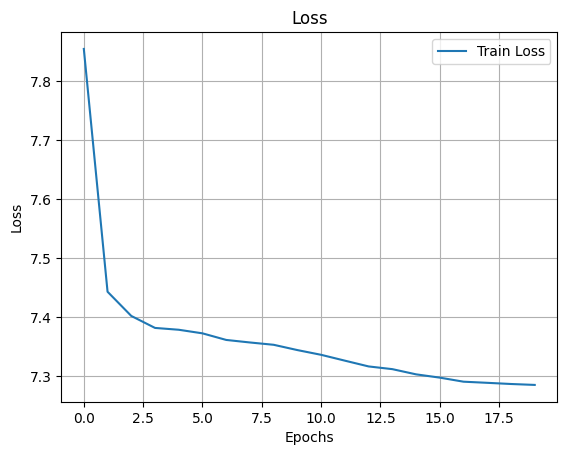

In [ ]:
plot_loss_hist(losses_hist_ssl)

Working through some highlights:
- We define our model, and put it on the device (a CPU or GPU)
- We define "criteria", these are the functions which will calculate the loss (how wrong the model was) from masked language modeling and next sentence prediction
- We define an optimizer, which will look at how large the loss was and update the model accordingly
- We go over all the data over n epochs
- We iterate over all batches of the data
- We mask our batch randomly with the masking function we defined previously
- We run the masked tokens, along with location information and where the masked tokens are, through the model. We get back predictions for next sentence prediction and predictions as to what the model thinks each masked token should be
- We pass our predictions through each respective criterion, with what the outputs should have been, to calculate loss
- We call loss.backward() to calculate how the model should change to be less wrong at this particular example
- We allow the optimizer to update the model based on the model's performance on this batch

# Fine Tuning BERT

The exact process of fine tuning depends on the type of data you're trying to fine tune against. Let's use sentiment analysis as an example.

Now have a BERT model that has some understanding of text. Let's use it to do something. The amazon_polarity dataset is an open dataset from amazon that contains information about whether a review is positive or negative. It consists of a big batch of review titles, review content, and labels saying if the review is positive or negative.

In [ ]:
fine_tune_ds= load_dataset('fancyzhx/amazon_polarity')

for elem in fine_tune_ds['train']:
    print(elem)
    break

README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


We are going to use this data to fine tune our BERT model to predict if the review is positive or negative.

First we need to turn this data into data that makes sense in a BERT model. The exact approach for this process can vary from task to task. Luckily for us this dataset consists of pairs of sentences (the title and content) so we can format the fine-tuned data just like we formatted the pre-training data previously.

In [ ]:
def preprocess_ft_data(data, max_input_length, max_num=100000):

    data_tokens= []
    data_positional= []
    data_targets= []

    # unpacking data
    for i, elem in enumerate(data):

        # tokenizing the title and content
        sentence1= elem['title']
        sentence2= elem['content']
        tokens= tokenizer([sentence1, sentence2], truncation=True, padding=False,
                          max_length=max_input_length)
        sentence1_tokens= tokens['input_ids'][0]
        sentence2_tokens= tokens['input_ids'][1]

        # trimming down tokens
        if len(sentence1_tokens) + len(sentence2_tokens) > max_input_length:
            max_half= max_input_length // 2  # leaving space for [CLS] and [SEP]

            sentence1_tokens= [101] + sentence1_tokens[-(max_half -1):]
            sentence2_tokens= sentence2_tokens[:(max_half -1)] + [102]

        # creating sentence tokens
        sentence_tokens= [0] * len(sentence1_tokens) + [1] * len(sentence2_tokens)

        # combining and padding
        pad_num= max_input_length - (len(sentence1_tokens) + len(sentence2_tokens))
        sequence_tokens= sentence1_tokens + sentence2_tokens + [0] * pad_num
        sentence_location_tokens= sentence_tokens + [1] * pad_num

        data_tokens.append(sequence_tokens)
        data_positional.append(sentence_location_tokens)
        data_targets.append(elem['label'])

        if i>= max_num:
            break

    return torch.tensor(data_positional), torch.tensor(data_tokens), torch.tensor(data_targets)


In [ ]:
# processing data into modeling data
train_pos, train_tok, train_targ= preprocess_ft_data(fine_tune_ds['train'], max_input_length)
test_pos, test_tok, test_targ= preprocess_ft_data(fine_tune_ds['test'], max_input_length)

# moving training to device
train_pos= train_pos.to(device)
train_tok= train_tok.to(device)
train_targ= train_targ.to(device)

# moving testing to device
test_pos= test_pos.to(device)
test_tok= test_tok.to(device)
test_targ= test_targ.to(device)

In [ ]:
train_pos.shape, train_tok.shape, train_targ.shape

(torch.Size([100001, 64]), torch.Size([100001, 64]), torch.Size([100001]))

In [ ]:
train_pos.shape[0] // batch_size

781

Supervised Training for fine tuning the model We can run the same pre training code as before, except on the fine tuned dataset and with the pre-trained model with a new classification head. Here we don't care about the masked language
modeling objective, so we are passing the original tokens into the model rather than the masked ones. If you wanted to do this properly you would artificially create a mask of all zeros.

Actually, when I ran this model I forgot to change any of this code, so I was still optimizing on masked language modeling as well as optimizing on the the classification of positive or negative reviews. I'm sure you could experiment with that strategy, there might be some merit to getting the model to better understand the type of text used in reviews specifically.

In [ ]:
def supervised_train(model, train_loc_batches, train_tkn_batches, train_lbl_batches, mask_batch,
                     batch_size, optimizer, scheduler, epochs=50, verbose:bool=True):

    # for logits directly
    classification_criterion= nn.BCEWithLogitsLoss()

    # keeping track of the losses across all epochs
    ft_losses= []
    lr_history= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        epoch_lr_history= []

        # --- training steps ---
        for i in tqdm(range(0, train_loc_batches.shape[0], batch_size),
                      total=len(train_loc_batches) // batch_size):

            if i+batch_size>= train_loc_batches.shape[0]:
                break

            # getting batch
            train_pos_batch = train_loc_batches[i : i+batch_size]
            train_tok_batch = train_tkn_batches[i : i+batch_size]
            train_targ_batch= train_lbl_batches[i : i+batch_size]

            # zeroing out gradients from last iteration
            optimizer.zero_grad()
            # masking the tokens in the input sequence --- we do not use masked_tokens in the
            # fine tuning process since after we train our model, the [MASK] token will never be
            # seen when the model is actually being used and making inferences
            # masked_tokens, masked_token_locations= mask_batch(train_tok_batch)

            # --- forward pass and get loss --- generating class
            clsf_logits, _= model(train_tok_batch, train_pos_batch)
            # calculating loss for next sentence classification
            # we are not optimizing the masked language modeling objective
            loss= classification_criterion(clsf_logits.squeeze(), train_targ_batch.float())

            # --- backward pass and update the parameters using the gradient
            loss.backward()
            optimizer.step()
            scheduler.step()

            # keeping track of loss across the current epoch
            epoch_losses.append(float(loss))
            epoch_lr_history.append(scheduler.get_last_lr())

        # store loss per epoch
        ft_losses.append(np.mean(epoch_losses))
        lr_history.append(np.mean(epoch_lr_history))

        if verbose:
            print(f'======= Epoch {epoch+1} Completed =======')
            print(f'Average loss in this epoch: {ft_losses[-1]:.6f}')

    return ft_losses, lr_history


Before we fine tune let's replace the classifier with a randomly initialized model. This allows us to preserve BERT's general language understanding, but start fresh in terms of the part of the model that's doing the classification, which is good to do because we are classifying something completely different.

In [ ]:
# the new training objective is still binary classification, except these parameters will be used
# to decide if a review was positive or negative
model.classifier= ClassifierHead(d_model, 1, bias=True, fine_tune=True).to(device)


# train data has size 781, so 20 epochs have 15620 steps
epochs= 20
learning_rate= 5e-4

max_lr= learning_rate
min_lr= 1e-5
warmup_steps= 781 * 1  # 1 epoch of warmup
max_steps= 781 * epochs

# resetting the optimizer to have access to the parameters of the new head
optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999),
                             weight_decay=0.01, fused=use_fused)

scheduler= CosineLRDecay(optimizer, min_lr, max_lr, warmup_steps, max_steps)

losses_hist_ft, lr_hist_ft= supervised_train(model, train_pos, train_tok, train_targ, mask_batch,
                                             batch_size, optimizer, scheduler, epochs)


100%|██████████| 781/781 [01:44<00:00,  7.45it/s]


======= Epoch 1 Completed =======
Average loss in this epoch: 0.683546


100%|██████████| 781/781 [01:44<00:00,  7.51it/s]


======= Epoch 2 Completed =======
Average loss in this epoch: 0.514449


100%|██████████| 781/781 [01:43<00:00,  7.52it/s]


======= Epoch 3 Completed =======
Average loss in this epoch: 0.391017


100%|██████████| 781/781 [01:45<00:00,  7.39it/s]


======= Epoch 4 Completed =======
Average loss in this epoch: 0.347043


100%|██████████| 781/781 [01:44<00:00,  7.51it/s]


======= Epoch 5 Completed =======
Average loss in this epoch: 0.321731


100%|██████████| 781/781 [01:44<00:00,  7.50it/s]


======= Epoch 6 Completed =======
Average loss in this epoch: 0.302915


100%|██████████| 781/781 [01:44<00:00,  7.50it/s]


======= Epoch 7 Completed =======
Average loss in this epoch: 0.290109


100%|██████████| 781/781 [01:43<00:00,  7.55it/s]


======= Epoch 8 Completed =======
Average loss in this epoch: 0.275791


100%|██████████| 781/781 [01:44<00:00,  7.48it/s]


======= Epoch 9 Completed =======
Average loss in this epoch: 0.264214


100%|██████████| 781/781 [01:43<00:00,  7.52it/s]


======= Epoch 10 Completed =======
Average loss in this epoch: 0.254482


100%|██████████| 781/781 [01:44<00:00,  7.44it/s]


======= Epoch 11 Completed =======
Average loss in this epoch: 0.245947


100%|██████████| 781/781 [01:44<00:00,  7.51it/s]


======= Epoch 12 Completed =======
Average loss in this epoch: 0.237454


100%|██████████| 781/781 [01:43<00:00,  7.52it/s]


======= Epoch 13 Completed =======
Average loss in this epoch: 0.229663


100%|██████████| 781/781 [01:44<00:00,  7.50it/s]


======= Epoch 14 Completed =======
Average loss in this epoch: 0.223136


100%|██████████| 781/781 [01:43<00:00,  7.52it/s]


======= Epoch 15 Completed =======
Average loss in this epoch: 0.218710


100%|██████████| 781/781 [01:44<00:00,  7.51it/s]


======= Epoch 16 Completed =======
Average loss in this epoch: 0.213428


100%|██████████| 781/781 [01:43<00:00,  7.53it/s]


======= Epoch 17 Completed =======
Average loss in this epoch: 0.211334


100%|██████████| 781/781 [01:43<00:00,  7.53it/s]


======= Epoch 18 Completed =======
Average loss in this epoch: 0.208949


100%|██████████| 781/781 [01:45<00:00,  7.41it/s]


======= Epoch 19 Completed =======
Average loss in this epoch: 0.207470


100%|██████████| 781/781 [01:45<00:00,  7.41it/s]

======= Epoch 20 Completed =======
Average loss in this epoch: 0.206986


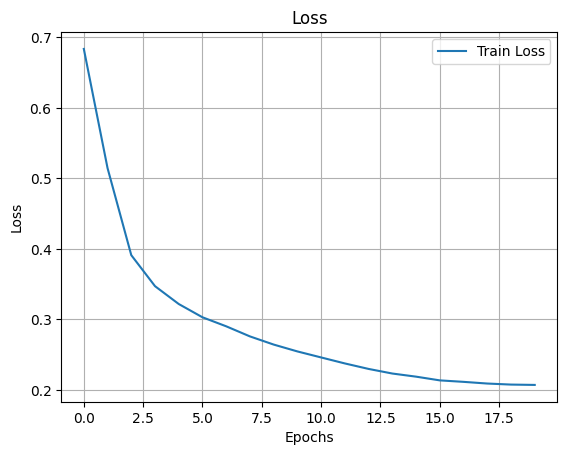

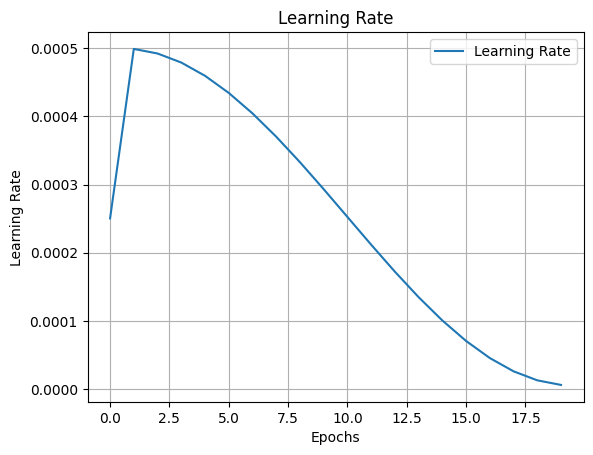

In [ ]:
plot_loss_hist(losses_hist_ft)
print("\n")
plot_lr_hist(lr_hist_ft)

# Inferring BERT

This dataset has a test set, so we can apply this fine tuned BERT model to see how good it is at classifying reviews it's never seen before.

In [ ]:
def test_accuracy(model, test_loc_batches, test_tkn_batches, test_lbl_batches, batch_size):

    is_correct= []
    predicted_class= []
    original_class= []

    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, test_loc_batches.shape[0], batch_size)):

            if i+batch_size>= test_loc_batches.shape[0]:
                break

            # getting batch
            test_pos_batch = test_loc_batches[i : i+batch_size]
            test_tok_batch = test_tkn_batches[i : i+batch_size]
            test_targ_batch= test_lbl_batches[i : i+batch_size]

            # making prediction, not masking anything
            clsf_logits, _= model(test_tok_batch, test_pos_batch)

            # converting logits to probabilities then rounding to classifications
            res= torch.sigmoid(clsf_logits).round().squeeze(dim=-1)

            # keeping track of the original class (positive or negative) and if the model was correct
            original_class.extend(test_targ_batch.cpu().tolist())
            is_correct.extend((res == test_targ_batch).cpu().tolist())
            predicted_class.extend(res.detach().cpu().tolist())

    # accuracy rate, original_class, and predicted_class
    return (sum(list(is_correct)) / len(is_correct)), original_class, predicted_class


In [ ]:
acc, original_class, predicted_class= test_accuracy(model, test_pos, test_tok, test_targ, batch_size)
print(f'\nBERT-based model accuracy: {(acc * 100):02.2f}%')

100%|█████████▉| 781/782 [00:08<00:00, 89.53it/s]


BERT-based model accuracy: 84.78%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(original_class, predicted_class))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     49405
           1       0.85      0.85      0.85     50563

    accuracy                           0.85     99968
   macro avg       0.85      0.85      0.85     99968
weighted avg       0.85      0.85      0.85     99968



We got a model that could classify if a review was positive or negative with a **84.78% accuracy**. That might not sound that impressive, but the BERT model used in this example is virtually microscopic. If you used more encoder blocks, a larger model dimension, and played around with a few other model parameters I think you could easily pass 90%.

We actually created a BERT style model. We explored tokenization, data processing, embedding, multi-headed self-attention, pointwise feed forward, pre-training, and fine tuning. By the end of that process we had created a BERT style model, trained it on Wiki articles to understand text, then fine-tuned it to classify if product reviews were positive or negative.

In [ ]:
# https://towardsdatascience.com/bert-intuitively-and-exhaustively-explained-48a24ecc1c8a
# https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/BERTFromScratch.ipynb